In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("darkgrid")

In [173]:
data = pd.read_csv('../input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

In [174]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


# Data Preprocessing

The UDI and Product ID column is not needed as it doesnt carry any useful information

In [176]:
data = data.drop(["UDI",'Product ID'],axis=1)
data.head(3)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure


### Note : We will focus on target detection for now and ignore error type

# Pre Processing for Prediction 

## Encoding

In [180]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

label_encoder.fit(data['Target'])
data['Target'] = label_encoder.transform(data['Target'])

In [181]:
data.tail()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure
9999,M,299.0,308.7,1500,40.2,30,0,No Failure


In [182]:
data = data.rename(columns = {'Air temperature [K]':'airtemp',
                      'Process temperature [K]':'processtemp',
                      'Rotational speed [rpm]':'rpm',
                      'Torque [Nm]':'torque',
                      'Tool wear [min]':'toolwear'})

## Test Tain Split

In [183]:
from sklearn.model_selection import train_test_split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Failure Type','Target', 'Type'],axis=1),
                                                    data['Target'], test_size=0.3, random_state=42)

## Prediction

In [185]:
import time

from sklearn.metrics import accuracy_score,classification_report
classifier=[]
imported_as=[]

#LGBM
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
classifier.append('LightGBM')
imported_as.append('lgbm')

#MultiLayerPerceptron
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
classifier.append('Multi Layer Perceptron')
imported_as.append('mlp')

#Bagging
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
classifier.append('Bagging')
imported_as.append('bc')

#GBC
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
classifier.append('Gradient Boosting')
imported_as.append('gbc')

#ADA
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
classifier.append('Ada Boost')
imported_as.append('ada')

#XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb = XGBClassifier() 
classifier.append('XG Boost')
imported_as.append('xgb')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
classifier.append('Logistic Regression')
imported_as.append('lr')

#RFC
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rfc')

#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
classifier.append('k Nearest Neighbours')
imported_as.append('knn')

#SVM
from sklearn.svm import SVC
svc = SVC()
classifier.append('Support Vector Machine')
imported_as.append('svc')

#Grid
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100, 1000,2000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
classifier.append('SVM tuning grid')
imported_as.append('grid')

#STcaking
from sklearn.ensemble import StackingClassifier
estimators=[('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
            ('svr',SVC(random_state=42))]
stc = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
classifier.append('Stacked (RFR & SVM)')
imported_as.append('stc')

classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
print('All Models Imported\nModels stored in dataframe called classifiers')

All Models Imported
Models stored in dataframe called classifiers


In [186]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [187]:
display(classifiers)

,Classifier,Imported as
0,LightGBM,lgbm
1,Multi Layer Perceptron,mlp
2,Bagging,bc
3,Gradient Boosting,gbc
4,Ada Boost,ada
5,XG Boost,xgb
6,Logistic Regression,lr
7,Random Forest,rfc
8,k Nearest Neighbours,knn
9,Support Vector Machine,svc


In [188]:
models_to_test = [bc,gbc,ada,rfc,mlp,lr,knn,stc]

In [189]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 9069 to 7270
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   airtemp      7000 non-null   float64
 1   processtemp  7000 non-null   float64
 2   rpm          7000 non-null   int64  
 3   torque       7000 non-null   float64
 4   toolwear     7000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 328.1 KB


In [190]:
classification = Modelling(X_train,y_train,X_test,y_test,models_to_test)
classification.fit()

BaggingClassifier() has been fit
GradientBoostingClassifier() has been fit
AdaBoostClassifier() has been fit
RandomForestClassifier() has been fit
MLPClassifier() has been fit
LogisticRegression() has been fit
KNeighborsClassifier(n_neighbors=1) has been fit
StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr', SVC(random_state=42))],
                   final_estimator=LogisticRegression()) has been fit


In [191]:
classification.results()

,Models,Accuracy,Runtime (s)
0,RandomForestClassifier,98.600,0.869807
1,GradientBoostingClassifier,98.567,0.844978
2,StackingClassifier,98.567,1.397702
3,BaggingClassifier,98.500,0.179683
4,AdaBoostClassifier,97.433,0.303414
5,LogisticRegression,97.367,0.132963
6,MLPClassifier,97.133,1.525025
7,KNeighborsClassifier,95.933,0.139810


In [192]:
print('BestModel is:',  classification.best_model(type='name'))
print('Accuracy of model:',classification.best_model_accuracy())
print('Training Runtime in seconds',classification.best_model_runtime())
print('Classification Matrix:\n')
print(classification.best_model_clmatrix())

BestModel is: RandomForestClassifier
Accuracy of model: 98.6
Training Runtime in seconds 0.87
Classification Matrix:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2907
           1       0.85      0.67      0.75        93

    accuracy                           0.99      3000
   macro avg       0.92      0.83      0.87      3000
weighted avg       0.99      0.99      0.99      3000



## Analyzing the final model

In [193]:
final_model = RandomForestClassifier()
final_model.fit(X_train,y_train)

RandomForestClassifier()

In [194]:
y_pred = final_model.predict(X_test)

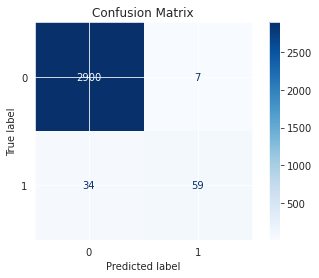

In [195]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Inference

In [205]:
data = data.rename(columns={
    'Air temperature [K]': 'airtemp',
    'Process temperature [K]': 'processtemp',
    'Rotational speed [rpm]': 'rpm',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'toolwear'
})

features = ['airtemp', 'processtemp', 'rpm', 'torque', 'toolwear']



def predict_new_failure(data_dict, model, encoder, features):

   
    new_df = pd.DataFrame([data_dict])

    new_df = new_df.rename(columns={
        'Air temperature [K]': 'airtemp',
        'Process temperature [K]': 'processtemp',
        'Rotational speed [rpm]': 'rpm',
        'Torque [Nm]': 'torque',
        'Tool wear [min]': 'toolwear'
    })


    new_X = new_df[features]

    prediction = model.predict(new_X)
    probability = model.predict_proba(new_X)

    
    if prediction[0] == 1:
        confidence = probability[0][1] * 100
        return f"Prédiction : PANNE DÉTECTÉE (Confiance : {confidence:.2f}%)"
    else:
        confidence = probability[0][0] * 100
        return f"Prédiction : Pas de Panne (Confiance : {confidence:.2f}%)"

In [207]:
normal_data = {
    "Air temperature [K]": 300.1,
    "Process temperature [K]": 310.2,
    "Rotational speed [rpm]": 1500,
    "Torque [Nm]": 40.5,
    "Tool wear [min]": 50
}


suspect_data = {
    "Air temperature [K]": 303.4,
    "Process temperature [K]": 312.8,
    "Rotational speed [rpm]": 1350,
    "Torque [Nm]": 75.2,  # Valeur élevée
    "Tool wear [min]": 210  # Valeur élevée
}

prediction_1 = predict_new_failure(normal_data, final_model, type_encoder, features)
print(prediction_1)

Prédiction : Pas de Panne (Confiance : 100.00%)


In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(rfc, f)